## Fraud Detection Using GNNs

## Graph approaches for fraud detection

Transactions can be represented as a graph, with users as nodes and interactions between them as edges. Traditional feature-based algorithms such as XGBoost and DLRM analyze individual nodes or edges, while graph-based approaches take into account the local context and structure of the graph, including neighboring nodes and edges.

In the traditional graph domain, there are various methods for making predictions based on graph structure, such as statistical approaches that aggregate features from adjacent nodes or edges. Algorithms like the [Louvain method](https://en.wikipedia.org/wiki/Louvain_method) and [InfoMap](https://towardsdatascience.com/infomap-algorithm-9b68b7e8b86) can identify communities and clusters of users on the graph. However, these methods lack the expressivity to fully consider the graph in its original format.

Graph neural networks (GNNs) offer a solution by representing local structural and feature context natively within the model. Through aggregation and message passing, information from both edges and nodes is propagated to neighboring nodes. Multiple layers of graph convolution result in a node's state containing information from nodes multiple layers away, effectively allowing the GNN to have a "receptive field" of nodes or edges multiple jumps away from the node or edge in question.

For fraud detection, GNNs can account for complex or longer chains of transactions that fraudsters use for obfuscation. Additionally, changing patterns can be addressed by retraining the model iteratively.

## ML for graph 

These are the general steps of ML on Graph, depending on the task, the methods used in each step may change and not all the steps may be needed.

1. Graph Representation: The first step in applying machine learning techniques to graphs is to represent the graph in a format that can be input into a machine learning model. This can be done using various graph representations such as adjacency matrices, adjacency lists, and edge lists.

2. Feature Extraction: Once the graph is represented, the next step is to extract features from the graph that can be used as input to a machine learning model. These features can include things like node degree, centrality measures, and graph traversal patterns.

3. Dimensionality Reduction: As the number of nodes and edges in a graph can be large, it is often necessary to reduce the dimensionality of the graph representation before applying machine learning techniques. This can be done using techniques like principal component analysis (PCA) and t-SNE.

4. Model Selection: After the graph is represented and features have been extracted, the next step is to select a machine learning model that can be applied to the graph data. Common models used for graph data include decision trees, random forests, and neural networks.

5. Training and Evaluation: Once the model is selected, it is trained on the graph data using a labeled training dataset. The model is then evaluated on a separate test dataset to assess its performance.

6. Predictions: After the model is trained, it can be used to make predictions on new graph data. For example, it can be used to predict the likelihood of a node in a graph being in a certain class or to predict the likelihood of a link between two nodes.

## Necessary imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
df = pd.read_csv("User0_credit_card_transactions.csv").sample( random_state=42)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 2199 to 2199
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   User            1 non-null      int64  
 1   Card            1 non-null      int64  
 2   Year            1 non-null      int64  
 3   Month           1 non-null      int64  
 4   Day             1 non-null      int64  
 5   Time            1 non-null      object 
 6   Amount          1 non-null      object 
 7   Use Chip        1 non-null      object 
 8   Merchant Name   1 non-null      int64  
 9   Merchant City   1 non-null      object 
 10  Merchant State  1 non-null      object 
 11  Zip             1 non-null      float64
 12  MCC             1 non-null      int64  
 13  Errors?         0 non-null      object 
 14  Is Fraud?       1 non-null      object 
dtypes: float64(1), int64(7), object(7)
memory usage: 128.0+ bytes


In [6]:
# We need to make sure that the samples we extracted have some rows where fraud is True
df [df['Is Fraud?'] == 'Yes'].shape

(0, 15)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

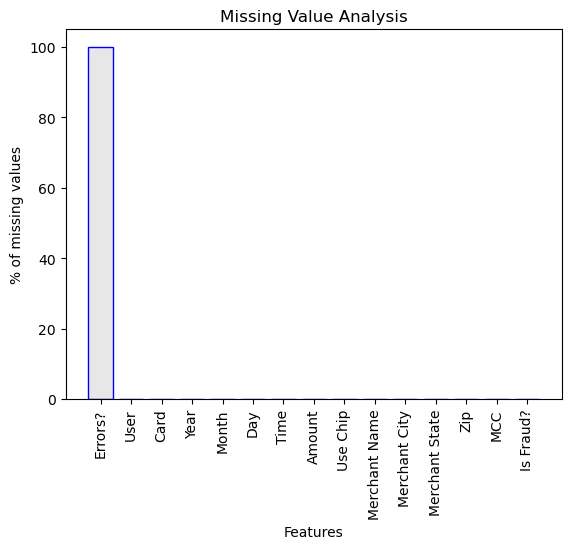

In [7]:
percent_missing=(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(percent_missing.sort_values(ascending=False).index,percent_missing.sort_values(ascending=False),color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')
plt.xticks(rotation=90)

The card_id is defined as one card by one user. A specific user can have multiple cards, which would correspond to multiple different card_ids for this graph. 
For this reason we will create a new column which is the concatenation of the column User and the Column Card

In [8]:
df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)

In [9]:
df.Amount.head(5)

2199    $32.26
Name: Amount, dtype: object

In [10]:
# We need to strip the ‘$’ from the Amount to cast as a float
df["Amount"]=df["Amount"].str.replace("$","").astype(float)

C:\Users\dhruv\AppData\Local\Temp\ipykernel_17640\206150659.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["Amount"]=df["Amount"].str.replace("$","").astype(float)


In [11]:
# time can't be casted to int so so opted to extract the hour and minute
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]

In [12]:
df.Hour

2199    06
Name: Hour, dtype: object

In [13]:
df.Minute

2199    35
Name: Minute, dtype: object

In [14]:
df = df.drop(["Time","User","Card"],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 2199 to 2199
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            1 non-null      int64  
 1   Month           1 non-null      int64  
 2   Day             1 non-null      int64  
 3   Amount          1 non-null      float64
 4   Use Chip        1 non-null      object 
 5   Merchant Name   1 non-null      int64  
 6   Merchant City   1 non-null      object 
 7   Merchant State  1 non-null      object 
 8   Zip             1 non-null      float64
 9   MCC             1 non-null      int64  
 10  Errors?         0 non-null      object 
 11  Is Fraud?       1 non-null      object 
 12  card_id         1 non-null      object 
 13  Hour            1 non-null      object 
 14  Minute          1 non-null      object 
dtypes: float64(2), int64(5), object(8)
memory usage: 128.0+ bytes


In [15]:
df["Errors?"].unique()

array([nan], dtype=object)

In [16]:
df["Errors?"]= df["Errors?"].fillna("No error")

The two columns Zip and Merchant state contains missing values which can affect our graph. Moreover these information can be extracted from the column Merchant City so we will drop them.

In [17]:
df = df.drop(columns=["Merchant State","Zip"],axis=1)

In [18]:
# change the is fraud column to binary 
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

In [19]:
df["Merchant City"]=LabelEncoder().fit_transform(df["Merchant City"])
df["Use Chip"]=LabelEncoder().fit_transform(df["Use Chip"])
df["Errors?"]=LabelEncoder().fit_transform(df["Errors?"])

In [20]:
df["Errors?"].unique()

array([0])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 2199 to 2199
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           1 non-null      int64  
 1   Month          1 non-null      int64  
 2   Day            1 non-null      int64  
 3   Amount         1 non-null      float64
 4   Use Chip       1 non-null      int32  
 5   Merchant Name  1 non-null      int64  
 6   Merchant City  1 non-null      int32  
 7   MCC            1 non-null      int64  
 8   Errors?        1 non-null      int32  
 9   Is Fraud?      1 non-null      int64  
 10  card_id        1 non-null      object 
 11  Hour           1 non-null      object 
 12  Minute         1 non-null      object 
dtypes: float64(1), int32(3), int64(6), object(3)
memory usage: 100.0+ bytes


In [22]:
# Create an empty graph
G = nx.MultiGraph()

# Add nodes to the graph for each unique card_id, merchant_name
G.add_nodes_from(df["card_id"].unique(), type='card_id')
G.add_nodes_from(df["Merchant Name"].unique(), type='merchant_name')


In [23]:
# Add edges and properties to the edges 
for _, row in df.iterrows():
    # Create a variable for each properties for each edge
    
        year = row["Year"],
        month = row["Month"],
        day = row["Day"],
        hour = row["Hour"],
        minute =row["Minute"],
        amount = row["Amount"],
        use_chip =  row["Use Chip"],
        merchant_city = row["Merchant City"],
        errors =  row["Errors?"],
        mcc = row['MCC']
    
 
        G.add_edge(row['card_id'], row['Merchant Name'], year = year , month = month , day = day ,
              hour = hour , minute = minute , amount = amount , use_chip = use_chip ,
              merchant_city = merchant_city , errors = errors , mcc = mcc)
  


In [24]:
# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the number of nodes and edges
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 2
Number of edges: 1


In [39]:
# Convert the graph to an adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

C:\Users\dhruv\AppData\Local\Temp\ipykernel_17640\1408587376.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G).todense()


AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

In [26]:
adj_matrix.shape

NameError: name 'adj_matrix' is not defined

We will retrieve the properties of a small sample of **nodes** in our graph (G) and print their properties.

In [27]:
# Get a small sample of the nodes in the graph
sample_nodes = list(G.nodes())[:10]

# Retrieve the properties of the sample nodes
node_properties = nx.get_node_attributes(G, 'type')

# Print the properties of the sample nodes
for node in sample_nodes:
    print(f"Node: {node}, Properties: {node_properties[node]}")


Node: 0_0, Properties: card_id
Node: -34551508091458520, Properties: merchant_name


In [28]:
sample_size = 5
for i, edge in enumerate(G.edges()):
    print(G.get_edge_data(*edge))
    if i >= sample_size - 1:
        break

{0: {'year': (2009,), 'month': (1,), 'day': (15,), 'hour': ('06',), 'minute': ('35',), 'amount': (32.26,), 'use_chip': (0,), 'merchant_city': (0,), 'errors': (0,), 'mcc': 5912}}


We will retrieve the properties of a small sample of **edges** in our graph (G) and print their properties.

In [29]:
# Retrieve the properties errors of all the edges
edge_properties = nx.get_edge_attributes(G, 'errors')

# Count the number of edges by property value
edge_count_by_property = Counter(edge_properties.values())

# Print the count of edges by property value
for property_value, count in edge_count_by_property.items():
    print(f"Property value: {property_value}, Count: {count}")


Property value: (0,), Count: 1


In [30]:
# Prepare the data for input into the model
edge_list = list(G.edges(data=True))

In [31]:
list(edge_list[i][2].values())

[(2009,), (1,), (15,), ('06',), ('35',), (32.26,), (0,), (0,), (0,), 5912]

We define a PyTorch neural network model called "FraudGNN" which is a type of Graph Neural Network. The model is a simple feedforward neural network with two fully connected (Linear) layers. The first layer has input_dim number of input units and hidden_dim number of output units, while the second layer has hidden_dim number of input units and 1 output unit.
The forward function of the model applies the linear layers to the input tensor "x" and applies a ReLU activation function to the output of the first linear layer.

We also prepare data for input into the model. We define the variable "edge_list" which is a list of edges and their associated data in a graph G. Then we create an empty list called "x" and iterates over each edge in the edge_list. For each edge, it extracts the values of the edge data, converts them to floats if needed, and append them to the list "x". Finally, we convert the list "x" to a PyTorch tensor with float datatype, which is ready to be input into the FraudGNN model.

In [32]:
class FraudGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FraudGNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.squeeze(-1)

# Prepare the data for input into the model
edge_list = list(G.edges(data=True))
x = []
for edge in edge_list:
    edge_values = list(edge[2].values())
    edge_values = [float(i[0]) if type(i) == tuple and type(i[0]) == str else i[0] if type(i) == tuple else i for i in edge_values]
    x.append(edge_values)
x = torch.tensor(x, dtype=torch.float)

In [33]:
target = torch.tensor(df['Is Fraud?'].values, dtype=torch.float)

In [34]:
# Define the model
input_dim = len(x[0])
hidden_dim = 16
model = FraudGNN(input_dim, hidden_dim)
num_epochs=201

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [35]:
# Train the model
for i in range(num_epochs):
    # Forward pass
    output = model(x)
    # Compute the loss
    loss = criterion(output, target)
    if i % 20 == 0:
        print(f'Epoch: {i}, Loss: {loss.item()}')
    # Zero the gradients
    optimizer.zero_grad()
    # Perform backpropagation
    loss.backward()
    # Update the parameters
    optimizer.step()

Epoch: 0, Loss: 0.0
Epoch: 20, Loss: 0.0
Epoch: 40, Loss: 0.0
Epoch: 60, Loss: 0.0
Epoch: 80, Loss: 0.0
Epoch: 100, Loss: 0.0
Epoch: 120, Loss: 0.0
Epoch: 140, Loss: 0.0
Epoch: 160, Loss: 0.0
Epoch: 180, Loss: 0.0
Epoch: 200, Loss: 0.0


### Method 2 

In this part we will base our work on the [paper](https://www.sciencedirect.com/science/article/abs/pii/S0957417421017449) **Inductive Graph Representation Learning for fraud detection** written by RafaëlVan Belle, Charles Van Damme, Hendrik Tytgat and JochenDe Weerdt. 

Charles has created a python library with the name of inductiveGRL for the experimental setup of their paper. 

Library overview :

1. Transaction Data
Any dataset that can be transformed into a graph can be used in our experimental setup. For our research, we used a real-life dataset to construct credit card transaction networks containing millions of transactions. This dataset includes information on the following features: anonymized identification of clients and merchants, merchant category code, country, monetary amount, time, acceptance, and fraud label. This real-life dataset is highly imbalanced and contains only 0.65% fraudulent transactions. Note that the demo data in this repository is artificaly generated for demonstration purposes. The Timeframes component derives the different timeframes for a rolling window setup given a step and window size.

2. Graph Construction
The GraphConstruction component constructs the graphs that will be used by graph representation learners (e.g. FI-GRL and GraphSAGE) to learn node embeddings. We designed the credit card transaction networks as heterogeneous tripartite graphs containing client, merchant and transaction nodes. Because of this tripartite setup, representations can be learned for the transaction nodes. Only the transaction nodes are configured with node features.

3. GraphSAGE
The HinSAGE code deploys a supervised, heterogeneous implementation of the GraphSAGE framework called HinSAGE, to learn embeddings of the transaction nodes in the aforementioned graphs.

4. FI-GRL
The FIGRL code learns embeddings of the transaction nodes in the aforementioned graphs using the Fast Inductive Graph Representation Learning Framework. We call the Matlab implementation of FI-GRL from our Jupyter notebooks, which requires an appropriate installation of matlab.engine in the same folder as the notebooks. If you wish to run FI-GRL from Python, please run the following command in Matlab:

cd (fullfile(matlabroot,'extern','engines','python'))
system('python setup.py install')

This will generate a folder in matlabroot\extern\engines\python\build\lib called 'matlab' please copy this folder and place it on the same location as the notebook from which you want to call matlab.engine. If you don't know your matlab root, running 'matlabroot' in Matlab will return the appropriate path.

5. Classifier
The penultimate component in our pipeline uses the transaction node embeddings to classify the transaction nodes as fraudulent or legitimate. We chose to rely on XGBoost as a classification model, but other classifiers can easily be implemented.

6. Evaluation
The Evaluation component contains functions for the Lift score, Lift curve and precision-recall curve. We focused on these evaluation metrics given the highly imbalanced nature of our dataset. However, this code can easily be extended to contain other evaluation metrics such as ROC plots.

In [36]:
#library installation
!pip install inductiveGRL 

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'

The conflict is caused by:
    inductivegrl 0.2 depends on stellargraph
    inductivegrl 0.1 depends on stellargraph

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict



ERROR: Cannot install inductivegrl==0.1 and inductivegrl==0.2 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [38]:
!pip install inductiveGRL

Defaulting to user installation because normal site-packages is not writeable
  Using cached inductiveGRL-0.2-py3-none-any.whl (6.6 kB)
  Using cached nbimporter-0.3.4-py3-none-any.whl (4.9 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached ipynb-0.5.1-py3-none-any.whl (6.9 kB)
  Using cached inductiveGRL-0.1.tar.gz (6.8 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'

The conflict is caused by:
    inductivegrl 0.2 depends on stellargraph
    inductivegrl 0.1 depends on stellargraph

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict



ERROR: Cannot install inductivegrl==0.1 and inductivegrl==0.2 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [37]:
# necessary imports of this part
from inductiveGRL.graphconstruction import GraphConstruction
from inductiveGRL.hinsage import HinSAGE_Representation_Learner

ModuleNotFoundError: No module named 'inductiveGRL'

In [ ]:
# Global parameters:
embedding_size = 64
add_additional_data = True

We will split our data 70% to train_data and 30% for inductive data that will be used to test the model's ability to generalize to new, unseen data.

First we calculate the cutoff point for the split using the formula "cutoff = round(0.7*len(df))" where 0.7 represents 70% of the data, and len(df) is the total number of rows in the dataframe. The round function is used to round the cutoff point to the nearest whole number.

Second we assign the first "cutoff" rows of the dataframe to the variable "train_data" by calling the head() function on the dataframe and passing the cutoff point as an argument. These rows will be used as the training data.

Last we assign the remaining rows of the dataframe (the rows after the cutoff point) to the variable "inductive_data" by calling the tail() function on the dataframe and passing the number of remaining rows (len(df) - cutoff) as an argument. These rows will be used as the inductive data.

In [ ]:
# we will take 70% of our dataset as traindata
cutoff = round(0.7*len(df)) 
train_data = df.head(cutoff)
inductive_data = df.tail(len(df)-cutoff)

In [ ]:
print('The distribution of fraud for the train data is:\n', train_data['Is Fraud?'].value_counts())
print('The distribution of fraud for the inductive data is:\n', inductive_data['Is Fraud?'].value_counts())

#### Graphe construction 

We will create a graph from a train_data using the GraphConstruction class. First we create the dataframes for the node data, second we define the nodes and edges, third  we create a dictionary of features, and finally we create a graph object, and calls the get_stellargraph() method to get the StellarGraph object.

In [ ]:
transaction_node_data = train_data.drop("card_id", axis=1).drop("Merchant Name", axis=1).drop('Is Fraud?', axis=1)
client_node_data = pd.DataFrame([1]*len(train_data["card_id"].unique())).set_index(train_data["card_id"].unique())
merchant_node_data = pd.DataFrame([1]*len(train_data["Merchant Name"].unique())).set_index(train_data["Merchant Name"].unique())

nodes = {"client":train_data.card_id, "merchant":train_data["Merchant Name"], "transaction":train_data.index}
edges = [zip(train_data.card_id, train_data.index),zip(train_data["Merchant Name"], train_data.index)]
features = {"transaction": transaction_node_data, 'client': client_node_data, 'merchant': merchant_node_data}

graph = GraphConstruction(nodes, edges, features)
S = graph.get_stellargraph()
print(S.info())

In [ ]:
#GraphSAGE parameters
num_samples = [2,32]
embedding_node_type = "transaction"

hinsage = HinSAGE_Representation_Learner(embedding_size, num_samples, embedding_node_type)
trained_hinsage_model, train_emb = hinsage.train_hinsage(S, list(train_data.index), train_data['Is Fraud?'], batch_size=5, epochs=10)